In [1]:
# Install jax if necessary
# !pip install --upgrade -q "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [2]:
# Install flax if necessary
# !pip install -q git+https://github.com/google/flax

In [3]:
# Install clu, orbax and upgrade jaxlib if necessary
# !pip install --upgrade -q jaxlib clu orbax

In [4]:
import os

import jax
import jax.numpy as jnp

from flax import linen as nn
from flax.training import train_state, checkpoints
import optax
import orbax

from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from typing import Any

In [5]:
# There is no need for tensorflow to use the gpu; it is only dataloading
tf.config.experimental.set_visible_devices([], "GPU")

In [6]:
# This finction loads the MNIST dataset into memory

def get_datasets(num_epochs, batch_size):
  train_ds = tfds.load('mnist', split='train') # 60,000 images (28x28)
  test_ds = tfds.load('mnist', split='test') # 10,000 images (28x28)
  
  # Let's cast the pixel values into floats and normalize them
  train_ds = train_ds.map(lambda sample: {'image': tf.cast(sample['image'], tf.float32) / 255.,
                                          'label': sample['label']})
  test_ds = test_ds.map(lambda sample: {'image': tf.cast(sample['image'], tf.float32) / 255.,
                                        'label': sample['label']})

  train_ds = train_ds.repeat(num_epochs).shuffle(10*batch_size) # allocating a buffer to randomly draw elements from
  train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1) # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency
  test_ds = test_ds.shuffle(10*batch_size) # allocating a buffer to randomly draw elements from
  test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1) # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency

  return train_ds, test_ds

In [7]:
# Setting up a template; the parameters (kernels, biases, etc.) are a separate object
class CNN(nn.Module):
    
  # __call__ subsumes __init__  
  @nn.compact
  def __call__(self, x, training):
    # Shape is (1, 28, 28, 1)
    x = nn.Conv(features=8, kernel_size=(3, 3))(x)
    # Shape is (1, 28, 28, 8)
    x = nn.gelu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    # Shape is (1, 14, 14, 8)
    x = nn.Conv(features=16, kernel_size=(3, 3))(x)
    # Shape is (1, 14, 14, 16)
    x = nn.gelu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    # Shape is (1, 7, 7, 16)
    x = x.reshape((x.shape[0], -1))  # flatten but keep batch dimension
    # Shape is (1, 784 = 7x7x16)
    x = nn.Dense(features=128)(x)
    x = nn.BatchNorm(use_running_average=not training)(x)
    # Shape is (1, 128)
    x = nn.gelu(x)
    x = nn.Dense(features=32)(x)
    x = nn.BatchNorm(use_running_average=not training)(x)
    # Shape is (1, 32)
    x = nn.gelu(x)
    x = nn.Dense(features=10)(x)
    # Shape is (1, 10)
    return x

In [8]:
# To create a summary for the Module instantiate with template data
print(CNN().tabulate(jax.random.PRNGKey(0), jnp.ones((1, 28, 28, 1)), training=False))


                                  CNN Summary                                   
┏━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ path       ┃ module    ┃ inputs      ┃ outputs    ┃ batch_stats ┃ params     ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│            │ CNN       │ -           │ float32[1… │             │            │
│            │           │ float32[1,… │            │             │            │
│            │           │ - training: │            │             │            │
│            │           │ False       │            │             │            │
├────────────┼───────────┼─────────────┼────────────┼─────────────┼────────────┤
│ Conv_0     │ Conv      │ float32[1,… │ float32[1… │             │ bias:      │
│            │           │             │            │             │ float32[8] │
│            │           │             │            │             │ kernel:    │
│            │           │ 

Let's create a single dataclass that represents the entire training state, including step number, parameters, and optimizer state. This class will subclass flax.training.train_state.TrainState 

The clu library contains utils for common ML training loops. Here we will use it for evaluation metrics.

In [9]:
from clu import metrics
from flax import struct                # Flax dataclasses which could be safely processed with JAX 

In [10]:
# A set of metrics in a safe dataclass
@struct.dataclass
class Metrics(metrics.Collection):
  accuracy: metrics.Accuracy
  loss: metrics.Average.from_output('loss')

In [11]:
from typing import Any

In [12]:
class TrainState(train_state.TrainState):
  # Our train state will have metrics attribute
  metrics: Metrics
  # and batch_stats
  batch_stats: Any     
  # It will also have a dropout key
  key: jax.random.KeyArray

In [13]:
# We also need JAX PRNGKey for the parameter initialization
root_key = jax.random.PRNGKey(42)
main_key, params_key, dropout_key = jax.random.split(key=root_key, num=3)

In [14]:
# Initialize the model
cnn = CNN()
# initialize parameters by passing a template image
variables = cnn.init(params_key, 
                jnp.ones([1, 28, 28, 1]), 
                training=False)
params = variables['params']
batch_stats = variables['batch_stats']

In [15]:
# The optimizer parameters
learning_rate = 0.0006
tx=optax.adam(learning_rate)

In [16]:
# Lets create the training state
# The Module foward pass will be in the TrainState apply function. 
state = TrainState.create(
      apply_fn=cnn.apply, 
      params=params,
      batch_stats=batch_stats,
      key=dropout_key, 
      tx=tx,
      metrics=Metrics.empty())

In [17]:
ckpt_dir = 'checkpoints'

# If the checkpoint directory is not empty we can load and start fine-tuning a pre-trained state
if os.path.exists(ckpt_dir):
    where = ckpt_dir + "/0/default/"
    state = checkpoints.restore_checkpoint(where, target=state)

The training step takes the following actions on a batch:
    
    1. Takes a forward pass with the current state parameters.
    2. Evaluates cross entropy loss.
    3. Evaluates the gradient of the loss function with jax.grad
    4. Applies a pytree of gradients to update the model parameters.
    
We trace the entire train_step function and just-in-time compile it with XLA.

In [18]:
@jax.jit
def train_step(state, batch):

  #Below the loss function will be evaluated with the current state parameters
  def loss_fn(params):
    logits, updates = state.apply_fn({'params': params, 'batch_stats': state.batch_stats}, 
                batch['image'],
                mutable=['batch_stats'],
                training=True) #Log(prob_i)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    return loss, (logits, updates)
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, (logits, updates)), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  state = state.replace(batch_stats=updates['batch_stats'])
  return state

We want to compute metrics during validation and testing, so their computation will be in a separate function. The lone * indicates that all following arguments are keyword-only arguments, that is, they can only be provided using their name, not as positional argument.

In [19]:
@jax.jit
def compute_metrics(*, state, batch):
  logits = state.apply_fn({'params': state.params, 'batch_stats': state.batch_stats}, 
                batch['image'], training=False)
  loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
  metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=batch['label'], loss=loss)
  metrics = state.metrics.merge(metric_updates)
  state = state.replace(metrics=metrics)
  return state

In [20]:
# Let's assure tfds shuffles are reproducible
tf.random.set_seed(42)

In [21]:
num_epochs = 32
batch_size = 32

# Download, shuffle, batch the data with the function we defined
train_ds, test_ds = get_datasets(num_epochs, batch_size)

In [22]:
len(train_ds), len(test_ds)

(60000, 312)

In [23]:
# since train_ds is replicated num_epochs times in get_datasets(), we divide by num_epochs
num_steps_per_epoch = train_ds.cardinality().numpy() // num_epochs

In [24]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [25]:
# We will also setup Orbax Checkpointer so we can save the best check points

if not os.path.exists(ckpt_dir):
    os.mkdir(ckpt_dir)

def best_fn(metrics):
  return metrics['accuracy']
    
options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=2, best_fn=best_fn, best_mode='max')
save_args = jax.tree_util.tree_map(
    lambda _: orbax.checkpoint.SaveArgs(aggregate=True), state)

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
checkpoint_manager = orbax.checkpoint.CheckpointManager(ckpt_dir, 
                        orbax_checkpointer, options)

Finally we are ready to run training

In [26]:
for step,batch in enumerate(train_ds.as_numpy_iterator()):

  if (step+1) % num_steps_per_epoch == 0: # one training epoch has passed
    epoch = (step+1) // num_steps_per_epoch
    
    for metric,value in state.metrics.compute().items(): # compute metrics
      metrics_history[f'train_{metric}'].append(value) # record metrics
    state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

    # Compute metrics on the test set after each training epoch
    test_state = state
    for test_batch in test_ds.as_numpy_iterator():
      test_state = compute_metrics(state=test_state, batch=test_batch)
        

    for metric, value in test_state.metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    
    test_accuracy = {'accuracy': metrics_history['test_accuracy'][-1].item() * 100}
    
    print(f"train epoch: {epoch}, "
          f"loss: {metrics_history['train_loss'][-1]}, "
          f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
    print(f"test epoch: {epoch}, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")
    
    checkpoint_manager.save(epoch, state, metrics=test_accuracy, save_kwargs={'save_args': save_args})
    
  # Run optimization steps over training batches and compute batch metrics
  state = train_step(state, batch) # get updated train state (which contains the updated parameters)
  state = compute_metrics(state=state, batch=batch) # aggregate batch metrics

train epoch: 1, loss: 0.4740208089351654, accuracy: 89.74119567871094
test epoch: 1, loss: 0.049454670399427414, accuracy: 98.53765869140625
train epoch: 2, loss: 0.040474504232406616, accuracy: 98.84333801269531
test epoch: 2, loss: 0.036129966378211975, accuracy: 98.7880630493164
train epoch: 3, loss: 0.02859232760965824, accuracy: 99.2066650390625
test epoch: 3, loss: 0.040753040462732315, accuracy: 98.71794891357422
train epoch: 4, loss: 0.020811421796679497, accuracy: 99.40833282470703
test epoch: 4, loss: 0.04829958826303482, accuracy: 98.50761413574219
train epoch: 5, loss: 0.017842981964349747, accuracy: 99.48666381835938
test epoch: 5, loss: 0.03671318292617798, accuracy: 98.83814239501953
train epoch: 6, loss: 0.01353911217302084, accuracy: 99.63166809082031
test epoch: 6, loss: 0.035251859575510025, accuracy: 98.92828369140625
train epoch: 7, loss: 0.011091266758739948, accuracy: 99.68333435058594
test epoch: 7, loss: 0.03597341477870941, accuracy: 98.94831848144531
train ep

Let's visualize the metrics during training

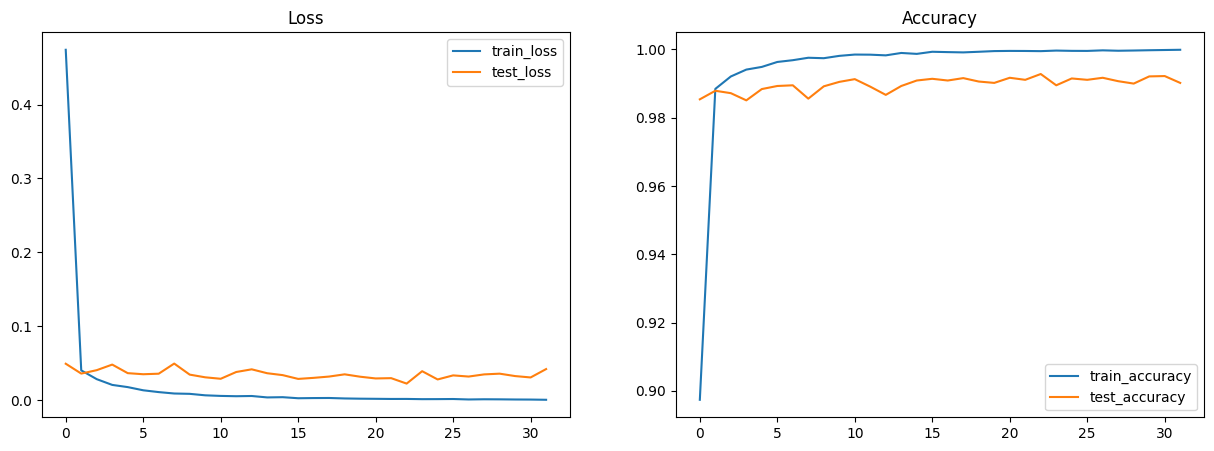

<Figure size 640x480 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

# And we can do inference on a test set. We will load the best saved model.

In [31]:
#We need an empty state template to restore the saved model
empty_state = TrainState.create(
      apply_fn=cnn.apply, 
      params=params,
      batch_stats=batch_stats,
      key=dropout_key, 
      tx=tx,
      metrics=Metrics.empty())

where = ckpt_dir + "/0/default/"

state_restored = checkpoints.restore_checkpoint(where, target=empty_state)

In [32]:
@jax.jit
def pred_step(state, batch):
  logits = state.apply_fn({'params': state.params, 'batch_stats': state.batch_stats}, 
                          test_batch['image'], training=False)
  return logits.argmax(axis=1)

test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(state_restored, test_batch)

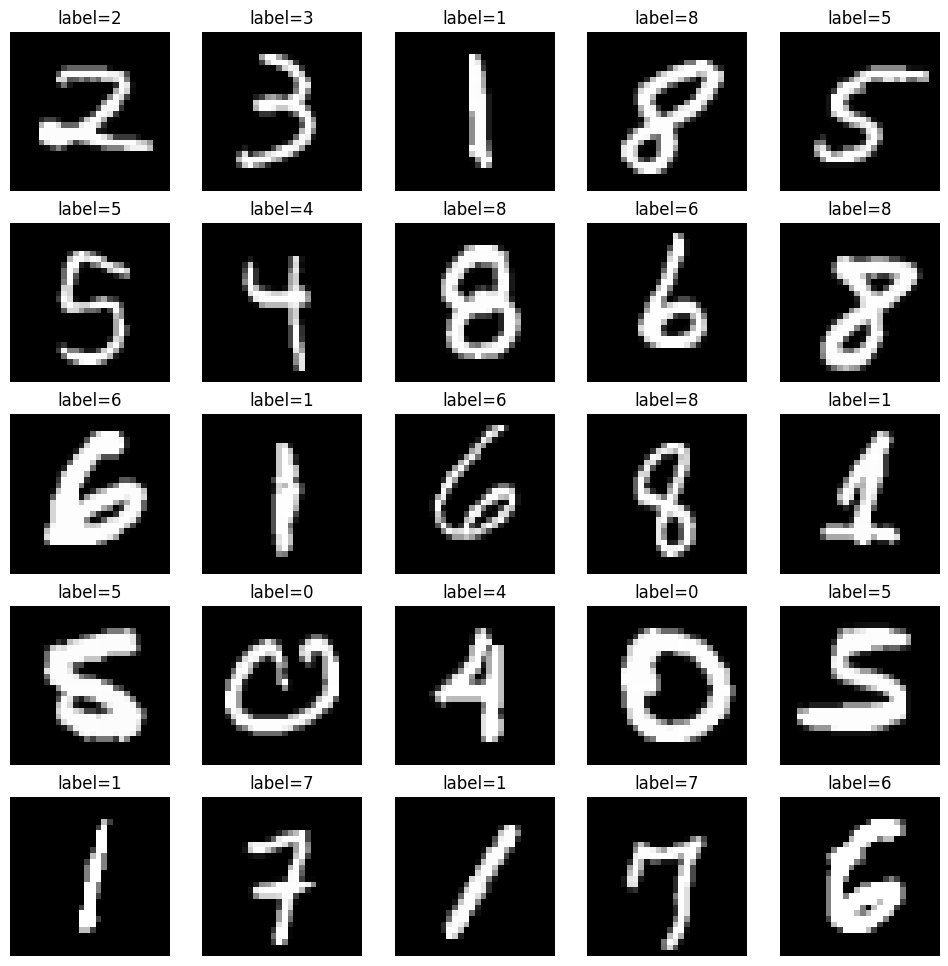

In [33]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
    ax.set_title(f"label={pred[i]}")
    ax.axis('off')

Homework: Play with the layers of the Model, the activation function and the hyperparameters to achieve Test accuracy over 99.5%

Push your code to GitHub on branch carrying your name.